In [1]:
import os
import sys
import random
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
from PIL import Image
from tqdm import tqdm
from tensorboardX import SummaryWriter
import albumentations as A
import yaml

from torchvision.models import vgg11, VGG11_Weights

sys.path.append('./modules')

# from UNet import UNeta
from Dataset import Dataset
from ImageLoader import ImageLoader

data = yaml.load(open('./settings.yaml', 'r'), yaml.Loader)

images_path = data['images_path']
masks_path = data['masks_path']
image_patches_path = data['image_patches_path']
mask_patches_path = data['mask_patches_path']

patch_size = data['patch_size']
batch_size = 1
sigma = data['sigma']
num_neg_samples = data['num_neg_samples']

folder = '2023.06.01 focal_loss'
model_name = 'vgg11'


transform = A.Compose([
    A.RandomRotate90(p=1),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

train_set = []
val_set = []

for i in [10, 20, 30, 40]:
    train_set.append("Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted{}.png".format(i))
for i in [50]:
    val_set.append("Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted{}.png".format(i))
    
train_ds = [[], []]
val_ds = [[], []]

for image_set, ds in [[train_set, train_ds], [val_set, val_ds]]:
    for image in image_set:
        print("Image:", image)
        patch_names = [file for file in os.listdir(os.path.join(image_patches_path, image)) if file[-4:] == '.npy']
        for patch in tqdm(range(len(patch_names))):
            image_patch = np.load(os.path.join(image_patches_path, image, patch_names[patch]))
            mask_patch = np.load(os.path.join(mask_patches_path, image, patch_names[patch]))
            
            image_patch = np.resize(image_patch, [3, patch_size, patch_size])
            mask_patch = nn.MaxPool2d(5)(torch.Tensor(np.expand_dims(mask_patch, [0])))
            mask_patch = np.array(mask_patch)
            
            ds[0].append(image_patch)
            ds[1].append(mask_patch)
            
train_ds = Dataset(train_ds[0], train_ds[1])
val_ds = Dataset(val_ds[0], val_ds[1])

/mmfs1/data/linok/.conda/envs/merons/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted10.png


100%|███████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:12<00:00, 29.49it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted20.png


100%|███████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:15<00:00, 27.93it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted30.png


100%|███████████████████████████████████████████████████████████████████████████████████████████| 392/392 [00:13<00:00, 29.74it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted40.png


100%|███████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:13<00:00, 28.97it/s]


Image: Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted50.png


100%|███████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:17<00:00, 29.89it/s]


In [2]:
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=10)
val_loader = torch.utils.data.DataLoader(val_ds, shuffle=False, batch_size=10)

epochs = 25000
lr = 5e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# unet = UNet(n_channels=1, n_classes=1).to(device)
model = vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=(patch_size // 5) ** 2 * 5, bias=True)
model = model.to(device)
lossFunc = torchvision.ops.sigmoid_focal_loss
opt = torch.optim.SGD(model.parameters(), lr=lr)

writer = SummaryWriter('./{}/runs/{}, lr={}'.format(folder, model_name, lr))

In [3]:
model_path = './2023.06.01 focal_loss/model_saves/vgg11, lr=0.005, epoch=1600.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [4]:
for x, y in val_loader:
    break

In [82]:
# input image: a batched numpy array or torch Tensor with dimensions (batch_size, 3, H, W)
# input mask: a batched numpy array or torch Tensor with dimensions (batch_size, 1, H, W)
# input transform: a transformation that is applied to each image and corresponding masks
# input scale_factor: the number of classes/intervals per mask
# output image: a batch numpy array with transformations applied and with dimensions (batch_size, 3, H, W)
# output mask_temp: a batch numpy array with transformations applied and with dimensions (batch_size, 1, H, W)


def transform_data(image, mask, transform, scale_factor):
    if type(image) != np.array:
        image = np.array(image)
    if type(mask) != np.array:
        mask = np.array(mask)
    
    for batch in range(image.shape[0]):
        transformed = transform(image=np.moveaxis(image[batch], 0, -1), mask=np.moveaxis(mask[batch], 0, -1))
        image[batch] = np.moveaxis(transformed['image'], -1, 0)
        mask[batch] = np.moveaxis(transformed['mask'], -1, 0)
    
    mask_temp = np.zeros(mask.shape)
    
    for interval in range(scale_factor):
        lower_bound = (1 / (scale_factor - 1)) * interval
        upper_bound = (1 / (scale_factor - 1)) * (interval + 1)
        mask_temp += (mask >= lower_bound) * (mask < upper_bound) * (interval + 1)
        
    return image, mask_temp

In [86]:
import matplotlib.pyplot as plt

model.eval()
plt.figure(figsize=[4.4 * 3, 4.4 * 50])
# plt.figure(figsize=[1 * 3, 1 * len(val_loader)])

loss_list = []

with torch.no_grad():
        model.eval()
        counter = 0

        for x, y in val_loader:
            x, y = transform_data(x, y, transform, 9)
            x = torch.Tensor(x)
            y = torch.Tensor(y)

            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)

            pred = model(x)
            loss = lossFunc(y, pred).mean()
            
            x = x.detach().cpu().numpy().squeeze()
            y = y.detach().cpu().numpy().squeeze()
            pred = pred.detach().cpu().numpy().squeeze()
            
            x = x[0]
        
            plt.subplot(50, 3, 3 * counter + 1)
            plt.axis('off')
            plt.title('x')
            plt.imshow(x[0], cmap='Greys_r')
            
            temp = np.zeros([patch_size, patch_size])
            for i in range(5):
                temp += y[i] * 0.25
            y = temp

            plt.subplot(50, 3, 3 * counter + 2)
            plt.axis('off')
            plt.title('y')
            plt.imshow(y, cmap='jet')
            
            temp = np.zeros([patch_size, patch_size])
            for i in range(5):
                temp += pred[i] * 0.25
            pred = temp

            plt.subplot(50, 3, 3 * counter + 3)
            plt.axis('off')
            plt.title('pred, mse_loss = {:.5f}'.format(loss))
            plt.imshow(pred, cmap='jet')

            counter += 1
            if counter == 50:
                break
        
_ = plt.show()

ValueError: Target size (torch.Size([10, 8000])) must be the same as input size (torch.Size([16000]))

<Figure size 950.4x15840 with 0 Axes>

In [ ]:
np.percentile(loss_list, 90)

In [10]:
# samples_x = []
# samples_y = []
# samples_pred = []

# with torch.no_grad():
#     counter = 0
#     for x, y in val_loader:
#         for batch_id in range(x.shape[0]):
#             x, y = np.array(x), np.array(y)
#             transformed = transform(image=x[batch_id], mask=y[batch_id])            
#             x[batch_id] = transformed['image']
#             y[batch_id] = transformed['mask']
#         x, y = torch.Tensor(np.moveaxis(x, -1, 1)), torch.Tensor(np.moveaxis(y, -1, 1))
        
#         x = x.to(device, dtype=torch.float)
#         y = y.to(device, dtype=torch.float)

#         pred = unet(x)
#         loss = lossFunc(pred, y)
        
#         x = x.detach().cpu().numpy().squeeze()
#         y = y.detach().cpu().numpy().squeeze()
#         pred = pred.detach().cpu().numpy().squeeze()
        
#         if loss > -1:
#             samples_x.append(x)
#             samples_y.append(y)
#             samples_pred.append(pred)
            
# print(len(samples_x))

In [9]:
# plt.figure(figsize=[4.4 * 3, 4.4 * 50])

# counter = 0
# for x, y, pred in np.moveaxis(np.array([samples_x, samples_y, samples_pred]), 1, 0):
#     plt.subplot(50, 3, 3 * counter + 1)
#     plt.axis('off')
#     plt.title('x')
#     plt.imshow(x, cmap='Greys_r')

#     plt.subplot(50, 3, 3 * counter + 2)
#     plt.axis('off')
#     plt.title('y')
#     plt.imshow(y, cmap='jet')

#     plt.subplot(50, 3, 3 * counter + 3)
#     plt.axis('off')
#     plt.title('pred, mse_loss = {:.5f}'.format(loss))
#     plt.imshow(pred, cmap='jet')
    
#     counter += 1
#     if counter == 50:
#         break
    
# _ = plt.show()

In [21]:
trial_img = './dataset/images/Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted50.png'
trial_mask = './dataset/masks/Bubbles_movie_01_x1987x2020x81_3cv2_NLM_template20_search62_inverted50.png.npy'

trial_img = plt.imread(trial_img)
trial_mask = np.load(trial_mask)
prediction = np.zeros(trial_mask.shape)

overlap_factor = 2

for y in tqdm(range(0, trial_img.shape[0] - patch_size, int(patch_size // overlap_factor))):
    for x in range(0, trial_img.shape[1] - patch_size, int(patch_size // overlap_factor)):
        patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
        patch = torch.Tensor(patch)
        patch = patch.to(device, dtype=torch.float)
        patch_pred = unet(patch)
        patch_pred = patch_pred.detach().cpu().numpy().squeeze()
        prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)
        
# taking care of edges + lower right corner
        
y = trial_img.shape[0] - patch_size
for x in tqdm(range(0, trial_img.shape[1] - patch_size, int(patch_size // overlap_factor))):
    patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
    patch = torch.Tensor(patch)
    patch = patch.to(device, dtype=torch.float)
    patch_pred = unet(patch)
    patch_pred = patch_pred.detach().cpu().numpy().squeeze()
    prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)
        
x = trial_img.shape[1] - patch_size
for y in tqdm(range(0, trial_img.shape[0] - patch_size, int(patch_size // overlap_factor))):
    patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
    patch = torch.Tensor(patch)
    patch = patch.to(device, dtype=torch.float)
    patch_pred = unet(patch)
    patch_pred = patch_pred.detach().cpu().numpy().squeeze()
    prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)
    
y = trial_img.shape[0] - patch_size
x = trial_img.shape[1] - patch_size
patch = trial_img[y:y+patch_size, x:x+patch_size].reshape([1, 1, patch_size, patch_size])
patch = torch.Tensor(patch)
patch = patch.to(device, dtype=torch.float)
patch_pred = unet(patch)
patch_pred = patch_pred.detach().cpu().numpy().squeeze()
prediction[y:y+patch_size, x:x+patch_size] = np.maximum(prediction[y:y+patch_size, x:x+patch_size], patch_pred)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.99it/s]


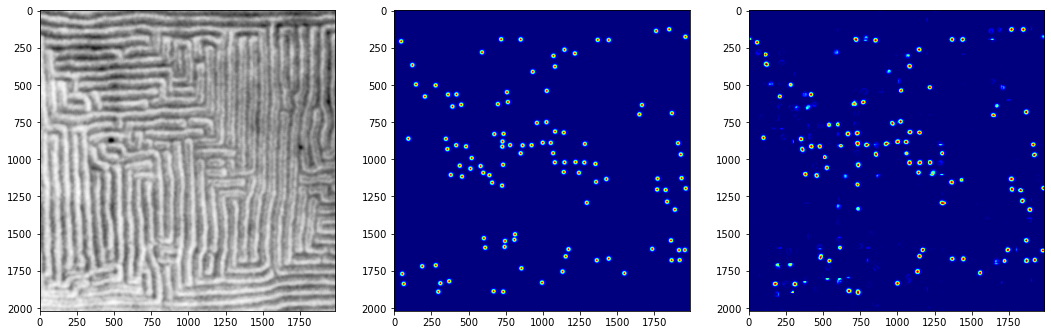

In [22]:
plt.figure(figsize=[6 * 3, 6 * 1])
plt.subplot(1, 3, 1)
plt.imshow(trial_img, cmap='Greys_r')
plt.subplot(1, 3, 2)
plt.imshow(trial_mask, cmap='jet')
plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='jet')

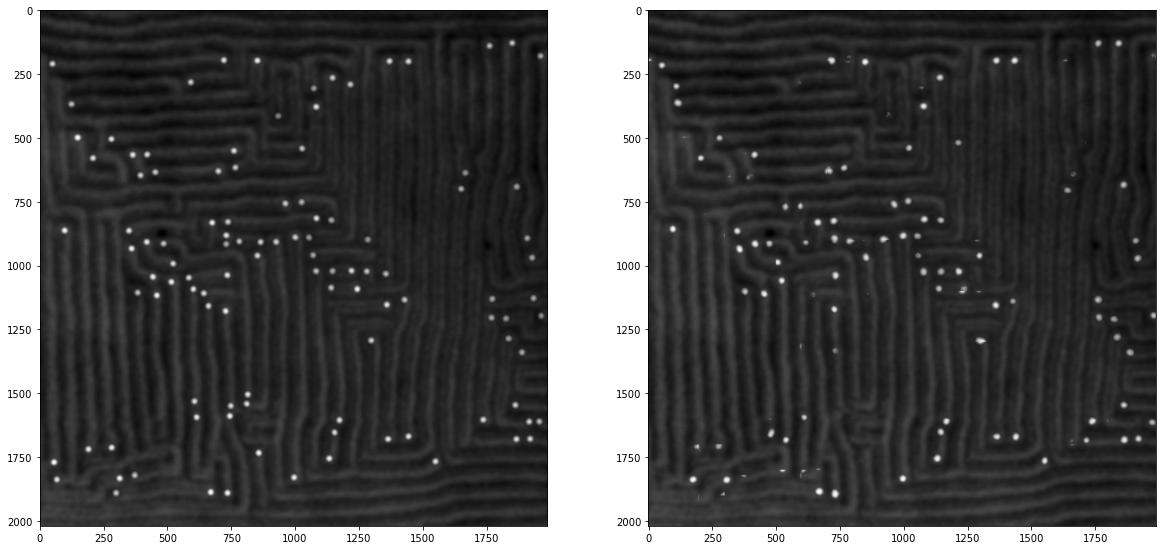

In [23]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1)
plt.imshow(trial_img * np.clip(trial_mask, 0.2, 1), cmap="Greys_r")
plt.subplot(1, 2, 2)
plt.imshow(trial_img * np.clip(prediction, 0.2, 1), cmap="Greys_r")
plt.show()